In [1]:
import os
import sys
import importlib
import glob
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.RationalApproximation import RationalApproximation_AAA
from scipy.special import gamma 
import pandas as pd 

In [148]:
@np.vectorize
def DistributedKernel(alpha): 
    return gamma(6 - alpha) / 120

In [149]:
class MultiTermKernel: 

    def __init__(self, phis, alphas, **kwargs):
        self.phis = phis
        self.alphas = alphas

        self.RATarget = np.vectorize(self.eval_RATarget) 
        self.kernel = np.vectorize(self.eval_kernel)

    def eval_kernel(self, t):
        return np.sum(self.phis / gamma(1 - self.alphas) * t **(-self.alphas))
    
    def eval_RATarget(self, t):
        return np.sum(self.phis * t ** (1 - self.alphas))

In [150]:
n_QF = 50

QFweight = 1 / (2*n_QF+3)

quadraturePoints01 = np.arange(0 + 0.5/n_QF,1 + 0.5/n_QF, 1/n_QF)
quadraturePoints12 = np.arange(1 + 0.5/n_QF,2 + 0.5/n_QF, 1/n_QF)

phis01 = DistributedKernel(quadraturePoints01) * QFweight
phis12 = DistributedKernel(quadraturePoints12) * QFweight

phi0 = DistributedKernel(0)
phi1 = DistributedKernel(1)
phi2 = DistributedKernel(2)

MTK01 = MultiTermKernel(phis01,quadraturePoints01)
MTK12 = MultiTermKernel(phis12,quadraturePoints12-1)

print(phis12)
print(quadraturePoints12)

[0.00382549 0.0037123  0.00360279 0.00349681 0.00339427 0.00329502
 0.00319897 0.003106   0.00301601 0.00292889 0.00284456 0.00276291
 0.00268385 0.0026073  0.00253317 0.00246139 0.00239186 0.00232452
 0.00225929 0.00219611 0.00213489 0.00207559 0.00201813 0.00196245
 0.0019085  0.00185622 0.00180555 0.00175644 0.00170883 0.00166269
 0.00161795 0.00157458 0.00153253 0.00149176 0.00145222 0.00141388
 0.00137669 0.00134063 0.00130565 0.00127171 0.00123879 0.00120686
 0.00117587 0.0011458  0.00111663 0.00108832 0.00106084 0.00103417
 0.00100829 0.00098316]
[1.01 1.03 1.05 1.07 1.09 1.11 1.13 1.15 1.17 1.19 1.21 1.23 1.25 1.27
 1.29 1.31 1.33 1.35 1.37 1.39 1.41 1.43 1.45 1.47 1.49 1.51 1.53 1.55
 1.57 1.59 1.61 1.63 1.65 1.67 1.69 1.71 1.73 1.75 1.77 1.79 1.81 1.83
 1.85 1.87 1.89 1.91 1.93 1.95 1.97 1.99]


In [151]:
T  = 1
dt = 1.e-6 # originally 1.e-6
Zmin, Zmax = 1/T,1/dt
tol = 1.e-10
MaxDegree = 30
nSupportPoints = 100

RA01 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, TargetFunction=MTK01.RATarget)
RA12 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, TargetFunction=MTK12.RATarget)

weights01 = RA01.c
poles01 = RA01.d
winf01 = RA01.c_inf
m01 = weights01.shape

weights12 = RA12.c
poles12 = RA12.d
winf12 = RA12.c_inf
m12 = weights12.shape

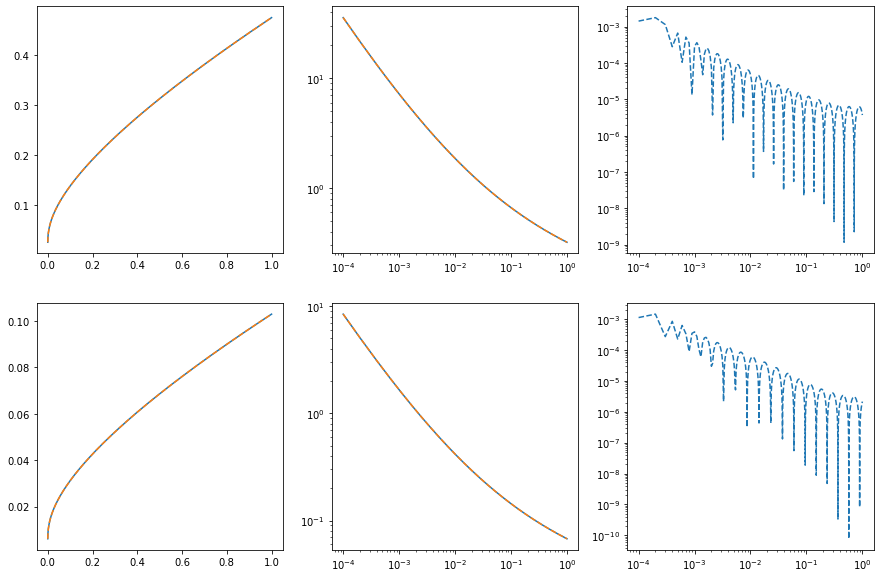

In [152]:
n_x = 10000
T = 1
x = np.linspace(1/n_x,T,T*n_x)

fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0][0].plot(x,MTK01.RATarget(x))
ax[0][0].plot(x,RA01.target_func(x), linestyle = "--")

ax[0][1].loglog(x,MTK01.kernel(x))
ax[0][1].loglog(x,RA01.appx_ker(x), linestyle = "--")

ax[0][2].loglog(x,np.abs(MTK01.kernel(x)-RA01.appx_ker(x)), linestyle = "--")

ax[1][0].plot(x,MTK12.RATarget(x))
ax[1][0].plot(x,RA12.target_func(x), linestyle = "--")

ax[1][1].loglog(x,MTK12.kernel(x))
ax[1][1].loglog(x,RA12.appx_ker(x), linestyle = "--")

ax[1][2].loglog(x,np.abs(MTK12.kernel(x)-RA12.appx_ker(x)), linestyle = "--")

In [153]:
def f_caputo(t): 
    return (t ** 5 - t**3) / np.log(t)

def f01(t,k): 
    return t**(k-2) * (k * (t-1) * np.log(t) -t + np.log(t) +1) / np.log(t)**2

def f12(t,k): 
    return (t**(k-4)*(2 * (t-1) + (- 5 - 2 * k * (t-1) + 3 *t) * np.log(t) + (k-2) * (3 + k * (t-1) - t) * np.log(t)**2)) / (np.log(t)**3)

def f(t,k): 
    return f01(t,k) + f12(t,k)

# def f(t,k=0):
#     return (-t + t * np.log(t) +1) / (t * np.log(t) ** 2) + (2*(t-1) - 2 * np.log(t)**2 + (t-3) * np.log(t)) / (t**3 * np.log(t)**3)

def a1(pole): 
    return (1 - np.exp(-pole * dt)) / pole

def a2(pole): 
    return (np.exp(-pole*dt) * (pole * dt + 2) + (pole * dt -2))/ (2 * pole * pole)

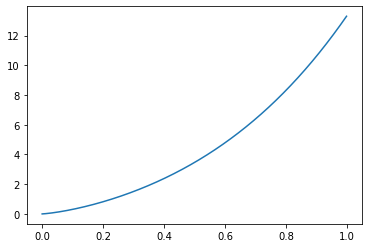

In [154]:
t = np.linspace(0.0001,1,1001)

# plt.plot(t,f01(t,5))
# plt.plot(t,f12(t,5))
# plt.plot(t,f01(t,5) + f12(t,5))
plt.plot(t,f(t,5))


In [167]:
dt = 0.0001

n_timesteps = int(T/dt) + 1

beta0 = phi0 / (2*n_QF + 3) + np.sum(weights01) - np.sum(weights12 * poles12)
beta1 = phi1 / (2*n_QF + 3) + np.sum(weights12) + winf01
beta2 = phi2 / (2*n_QF + 3) + winf12

modes01 = np.zeros((n_timesteps, m01[0])) 
modes12 = np.zeros((n_timesteps, m12[0])) 

u = np.zeros(n_timesteps) 
v = np.zeros(n_timesteps) 

# Initial conditions 
# Modes are already initially zero 
u[0] = 0
v[0] = 0 

for n in range(n_timesteps-1): 

    Q = np.sum(dt * weights01 * poles01 / (1 + dt * poles01)) - np.sum(dt * weights12 * poles12**2 / (1 + dt * poles12)) - beta0
    H = np.sum(poles01 / (1 + dt * poles01) * modes01[n]) - np.sum(poles12**2 / (1 + dt * poles12) * modes12[n])
    P = 1 - dt ** 2 / beta2 * Q + dt / beta2 * beta1
    
    v[n+1] = (v[n] + dt / beta2 * (f((n+1)*dt,6) + Q * u[n] + H)) / P 
    u[n+1] = u[n] + dt * v[n+1]

    modes01[n+1] = 1 / (1 + dt*poles01) * (modes01[n] + dt * weights01 * u[n+1])
    modes12[n+1] = 1 / (1 + dt*poles12) * (modes12[n] + dt * weights12 * u[n+1])

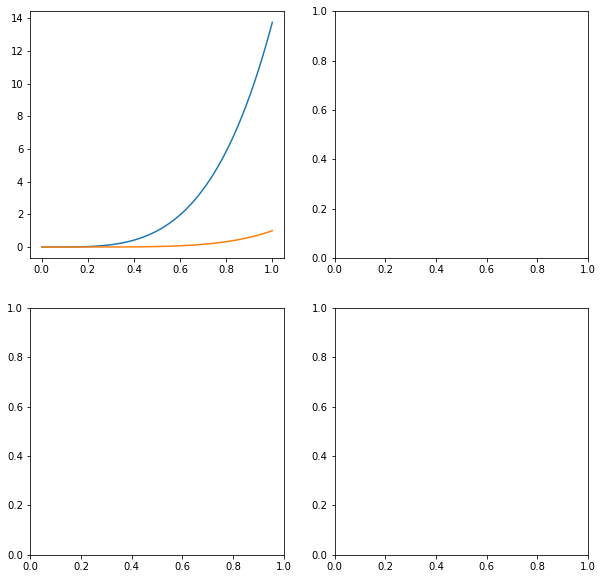

In [168]:
t = dt * np.asarray(range(n_timesteps))

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0][0].plot(t,u)
ax[0][0].plot(t,t**5)

# ax[0][1].plot(t,np.abs(u-t**5))

# ax[1][0].plot(t,v)
# ax[1][0].plot(t,5*t**4)

# ax[1][1].plot(t,np.abs(v-5*t**4))

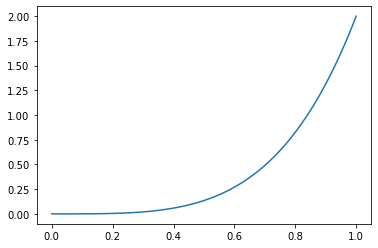

In [13]:
dt = 1e-4 
n_timesteps=10001
t = dt * np.asarray(range(n_timesteps))
t = t[1:-1]

plt.plot(t,(t**5-t**3)/np.log(t))

In [157]:
   # F = v[n] + (dt/2 * (-1/beta2)) * (beta0 * u[n] + beta1 * v[n] - np.sum(modes01[n] * poles01) + np.sum(modes12[n] * poles12**2) - f((n+1)*dt) - f((n)*dt))
    
    # H = (dt/2 * (-1/beta2)) * (beta0 * u[n] + beta0 * dt/2 * v[n] 
    #                            - np.sum(modes01[n] * poles01 * np.exp(-poles01 * dt)) - np.sum(poles01 * p01) * u[n] - np.sum(poles01 * p01) * dt/2 * v[n] - np.sum(poles01 * q01) * u[n] 
    #                            + np.sum(modes12[n] * poles12 ** 2 * np.exp(-poles12 * dt)) + np.sum(poles12 ** 2 * p12) * u[n] + np.sum(poles12 ** 2 * p12) * dt/2 * v[n] + np.sum(poles12**2*q12) * u[n]) 
    
    # G = (-dt / 2 / beta2) * (beta0 * dt / 2 + beta1 - np.sum(poles01 * p01) * dt / 2 + np.sum(poles12**2 * p12) * dt/2)

    # if n % 100 == 0: 
    #     print(n,F,H,G)

    # v[n+1] = (F + H) / (1-G)
    # u[n+1] = u[n] + dt/2 * (v[n+1] + v[n])

    # modes01[n+1] = np.exp(-poles01 * dt) * modes01[n] + p01 * u[n+1] + q01 * u[n] 
    # modes12[n+1] = np.exp(-poles12 * dt) * modes12[n] + p12 * u[n+1] + q12 * u[n] 